# Step 1: Import Libraries and data

## I mannually move the header of the variable to 2nd and 3rd column

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

# Specify the file path
file_path = 'D:\\PhD\\686\\A3\\lee08.csv'  # Update with your actual path

# Load the CSV file into a DataFrame
data = pd.read_csv(file_path)

# Step 2: Createa a Treatment varible =1 when margin >0

In [2]:
data['elected'] = (data['margin'] > 0).astype(int)

# Display the first few rows to verify
print(data.head())

   Unnamed: 0  voteshare  margin  elected
0           1   0.000000  -100.0        0
1           2   0.000000  -100.0        0
2           3   0.000000  -100.0        0
3           4  25.114423  -100.0        0
4           5  23.875193  -100.0        0


In [3]:
X = data['margin']
Y = data['voteshare']
D = data['elected']
interaction_term = D * X
cutoff = 0

# Step 3: Set up the weights and function to for the RD

In [4]:
def triangular_kernel(u):
    return np.maximum(1 - np.abs(u), 0)

In [5]:
def rd_with_kernel(X, Y, D, interact, h, robust=True):
     # Calculate weights using triangular kernel
    weights = triangular_kernel(X/h)
    
     # Keep data within bandwidth
    mask = np.abs(X) <= h
    X_copy = X[mask]
    Y_copy = Y[mask]
    D_copy = D[mask]
    interact_copy = interact[mask]
    weights = weights[mask]

    # Create the design matrix
    X_design = pd.DataFrame({
        'Intercept': 1,
        'X': X_copy,
        'D': D_copy,
        'Interaction': interact_copy
    })
     # Fit the weighted regression
    model = sm.WLS(Y_copy, X_design, weights=weights).fit(cov_type='HC0' if robust else 'nonrobust')

    # Extract the estimate and robust standard error for the treatment effect (D)
    estimate = model.params['D']
    standard_error = model.bse['D']

    return estimate, standard_error


# Step 4: Use the defined function and put the estimates into a table

In [6]:
# Define bandwidths
bandwidths = [1, 5, 10]

# Compute estimates and standard errors for each bandwidth
results = []

for h in bandwidths:
    estimate, se = rd_with_kernel(X, Y, D, interaction_term, h)
    results.append({'Bandwidth': h, 'Estimate': estimate, 'Standard Error': se})

# Convert results to a DataFrame for display
results_df = pd.DataFrame(results)

# Display the results
print("Regression Discontinuity Estimates with Triangular Kernel:")
print(results_df)

Regression Discontinuity Estimates with Triangular Kernel:
   Bandwidth  Estimate  Standard Error
0          1  9.234167        2.926568
1          5  6.811580        1.474229
2         10  5.936726        1.290608


# Step 5: Check if there is any manipulation around cutoff

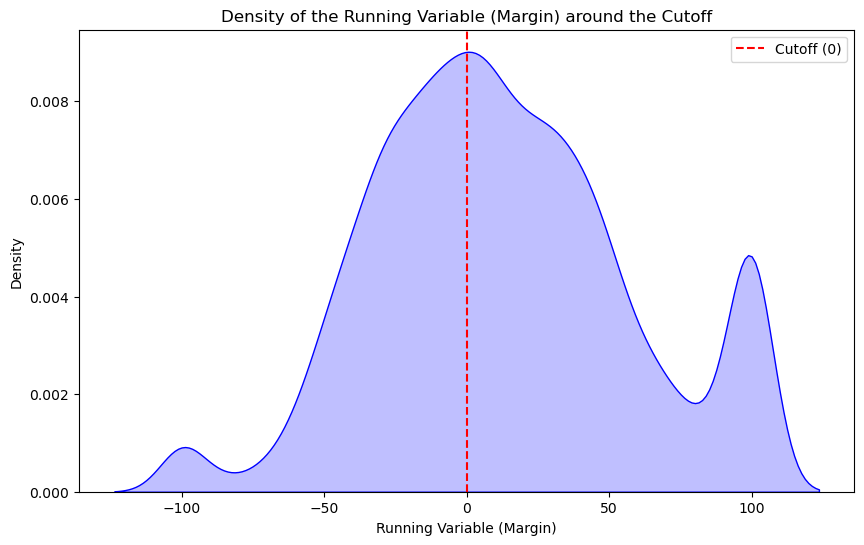

In [7]:
plt.figure(figsize=(10, 6))
sns.kdeplot(X, fill=True, color="blue", bw_adjust=1) 
plt.axvline(x=cutoff, color="red", linestyle="--", label="Cutoff (0)")  # Mark the cutoff
plt.title("Density of the Running Variable (Margin) around the Cutoff")
plt.xlabel("Running Variable (Margin)")
plt.ylabel("Density")
plt.legend()
plt.show()

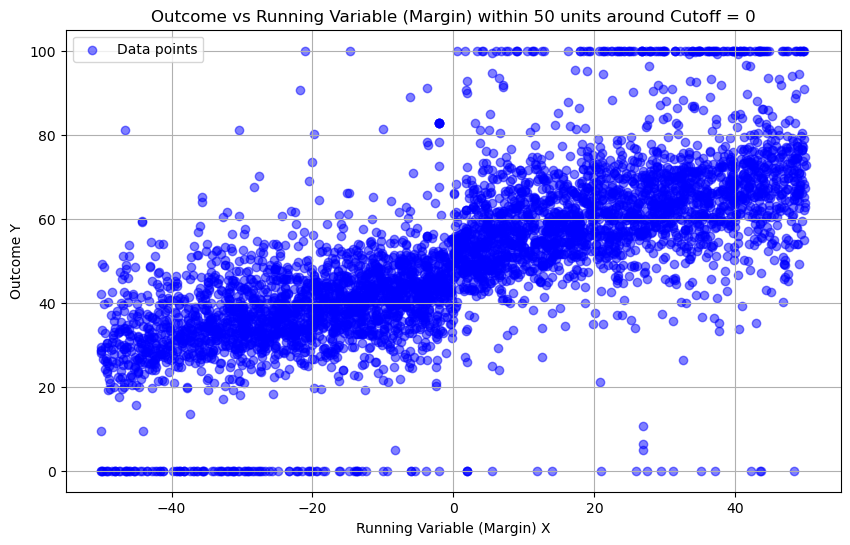

In [8]:
X = data['margin']  # Replace with the actual column name for the running variable
Y = data['voteshare']  # Replace with the actual column name for the outcome variable

mask = (X >= -50) & (X <= 50)
X_filtered = X[mask]
Y_filtered = Y[mask]

# Plot outcome Y vs running variable X within 50 units around the cutoff
plt.figure(figsize=(10, 6))
plt.scatter(X_filtered, Y_filtered, color='blue', alpha=0.5, label="Data points")
plt.title(f"Outcome vs Running Variable (Margin) within 50 units around Cutoff = {cutoff}")
plt.xlabel("Running Variable (Margin) X")
plt.ylabel("Outcome Y")
plt.grid(True)
plt.legend()
plt.show()


Looking at the density figure, around the cutoff, the density is smoothly increasing without any huge jump. It is reasonable to assume that there is no manupulation around the cutoff so margin is a valid running variable. We can see there is a small jump around the cutoff 0 in the second plot.

After regressing with different bandwith, we can see that smaller band with have larger estimates. This shows that there is indeed different effects across running variables and "winning the previous election" will increase you vote share by approx 9.23% using 1 as the bandwith and it is significant given the robust standard error.

# Bonus: Plot the weights with h=5 as an example

In [9]:
cutoff = 0  # Define the cutoff point
h = 5  # Define the bandwidth (you can change this)
X = data['margin'] 
D = data['elected']
data['interaction'] = data['margin'] * data['elected']
Interact = data['interaction']
mask = np.abs(X) <= h
X = X[mask].reset_index(drop=True)
Y = Y[mask].reset_index(drop=True)
D = D[mask].reset_index(drop=True)
I = Interact[mask].reset_index(drop=True)

In [10]:
n = len(X)
q = np.zeros((n, 4))  # 4 regressors for q_i (constant, X_i - c, I(X_i >= c), (X_i - c)*I(X_i >= c))
k = np.zeros(n)  # Kernel weights
w = np.zeros(n)  # Final weights

In [11]:
 for i in range(n):
    xi = X[i]
    # q_i: (1, X_i - c, I(X_i >= c), (X_i - c) * I(X_i >= c))
    q[i] = [1, xi - cutoff, int(xi >= cutoff), (xi - cutoff) * int(xi >= cutoff)]
        
    # Kernel weight k_i: k_i = k((X_i - c) / h)
    k[i] = triangular_kernel((xi - cutoff) / h)

In [12]:
# Matrix Q = q_i q_i'ki
Q = np.array([np.outer(q[i], q[i]) * k[i] for i in range(n)])
    
# Compute weights w_i
# Sum of q_i q_i' k_i (over all i)
Q_sum = np.sum(Q, axis=0)
    
# Invert the sum and calculate w_i
Q_inv = np.linalg.inv(Q_sum)
    
# e3' = (0, 0, 1, 0), we want to extract the third element (I(X_i >= c))
e3 = np.array([0, 0, 1, 0])
    
# Calculate w_i
for i in range(n):
    w[i] = np.dot(np.dot(e3, Q_inv), q[i]) * k[i]

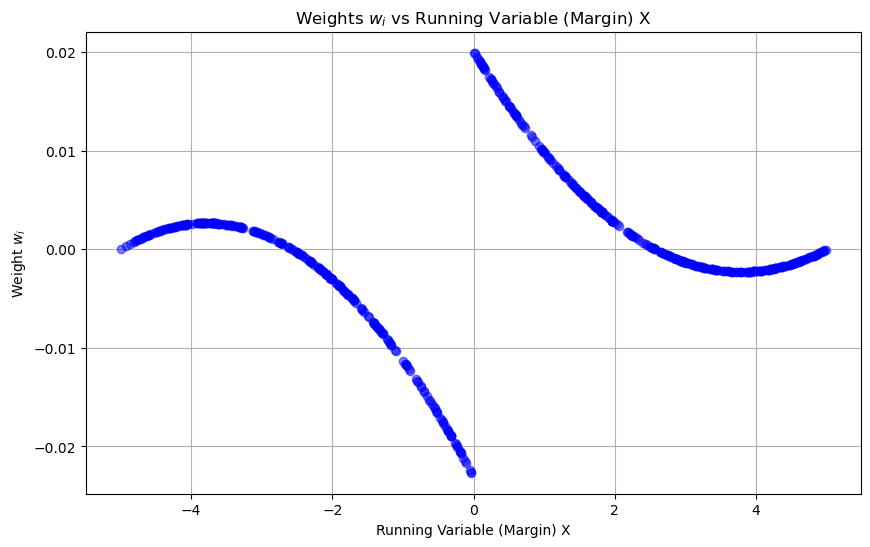

In [13]:
# Plot w_i vs. the running variable X
plt.figure(figsize=(10, 6))
plt.plot(X, w, 'o', color='blue', alpha=0.5)
plt.title("Weights $w_i$ vs Running Variable (Margin) X")
plt.xlabel("Running Variable (Margin) X")
plt.ylabel("Weight $w_i$")
plt.grid(True)
plt.show()